In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from __future__ import print_function

import math
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd


import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [0]:
train_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
test_data  = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

In [0]:
# train_data.describe()

In [0]:
# test_data.describe()

In [0]:
def pre_process_train_data(dataframe):
  features = dataframe.iloc[:,:-1]
  processed_features = features.copy()
  processed_features["rooms_per_person"] =  processed_features["total_rooms"] / processed_features["population"] 
  
  labels = pd.DataFrame()
  labels["median_house_value"] = dataframe.iloc[:,-1] / 1000.0
  return train_test_split(processed_features, labels, test_size = 0.2,shuffle=True)

def pre_process_test_data(dataframe):
  features = dataframe.iloc[:,:-1]
  processed_features = features.copy()
  processed_features["rooms_per_person"] =  processed_features["total_rooms"] / processed_features["population"] 
  
  labels = pd.DataFrame()
  labels["median_house_value"] = dataframe.iloc[:,-1] / 1000.0
  return processed_features, labels

In [0]:
X_train, X_val, y_train, y_val = pre_process_train_data(train_data)
X_test, y_test = pre_process_test_data(test_data)

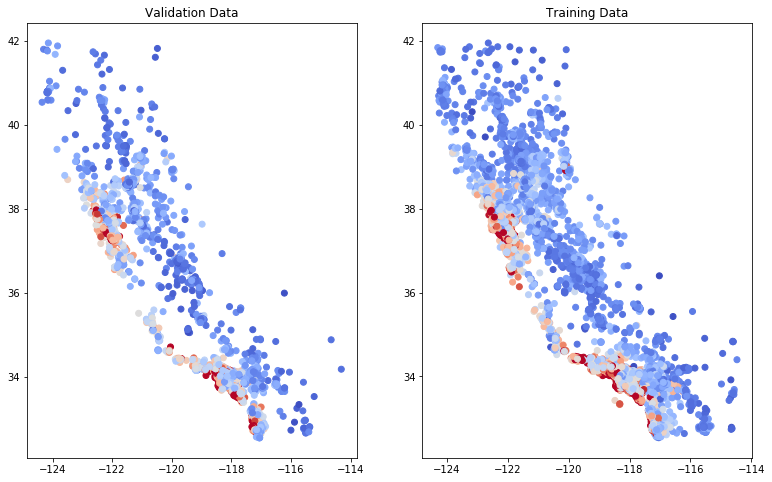

In [8]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")
plt.scatter(X_val["longitude"], X_val["latitude"],
            cmap="coolwarm",
            c=y_val["median_house_value"] / y_val["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")
plt.scatter(X_train["longitude"],
            X_train["latitude"],
            cmap="coolwarm",
            c=y_train["median_house_value"] / y_train["median_house_value"].max())
_ = plt.plot()

In [27]:
correlation_dataframe = X_train.copy()
correlation_dataframe["target"] = y_train["median_house_value"]

#correlation_dataframe.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
longitude,1.000000,-0.925557,-0.112107,0.044443,0.071318,0.100409,0.058369,-0.022472,-0.073913,-0.045881
latitude,-0.925557,1.000000,0.013519,-0.034868,-0.067803,-0.109337,-0.072537,-0.073336,0.139317,-0.142755
housing_median_age,-0.112107,0.013519,1.000000,-0.360539,-0.320332,-0.290849,-0.302428,-0.112530,-0.101130,0.109040
total_rooms,0.044443,-0.034868,-0.360539,1.000000,0.927627,0.859493,0.917508,0.189387,0.119284,0.124658
total_bedrooms,0.071318,-0.067803,-0.320332,0.927627,1.000000,0.881352,0.980452,-0.019760,0.046139,0.037979
population,0.100409,-0.109337,-0.290849,0.859493,0.881352,1.000000,0.910271,-0.005909,-0.135614,-0.031826
households,0.058369,-0.072537,-0.302428,0.917508,0.980452,0.910271,1.000000,0.000789,-0.034903,0.053171
median_income,-0.022472,-0.073336,-0.112530,0.189387,-0.019760,-0.005909,0.000789,1.000000,0.229228,0.694117
rooms_per_person,-0.073913,0.139317,-0.101130,0.119284,0.046139,-0.135614,-0.034903,0.229228,1.000000,0.205364
target,-0.045881,-0.142755,0.109040,0.124658,0.037979,-0.031826,0.053171,0.694117,0.205364,1.000000


In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True,count=None):
  ds = tf.data.Dataset.from_tensor_slices((dict(features),targets))
  if shuffle:
    ds = ds.shuffle(buffer_size=10000)
  ds = ds.batch(batch_size).repeat(count)
  return ds

In [0]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def train_model(learning_rate, optimizer, steps, batch_size, feature_columns, training_examples, training_targets, validation_examples, validation_targets):
 
  # optimizer can be SGD,Ftrl,etc.
  my_optimizer = getattr(tf.keras.optimizers,optimizer)(learning_rate=learning_rate, clipnorm =5.0)
  linear_regressor = tf.estimator.LinearRegressor(feature_columns = feature_columns,optimizer = my_optimizer) 
  
  training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn( training_examples, training_targets["median_house_value"], count=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], count=1, shuffle=False)

  print("Training model...")
  print("RMSE (on training data):")
  
  history = linear_regressor.train(input_fn=training_input_fn, steps=steps)
  
  training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
  training_predictions = np.array([item['predictions'][0] for item in training_predictions])
  
  validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
  validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
  
  # Compute training and validation loss.
  training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
  validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
  
  print("Model training finished.")
  print("Final RMSE (on training data): %0.3f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.3f" % validation_root_mean_squared_error)
  # Output a graph of loss metrics over periods.
  # plt.ylabel("RMSE")
  # plt.xlabel("Periods")
  # plt.title("Root Mean Squared Error vs. Periods")
  # plt.tight_layout()
  # plt.plot(training_rmse, label="training")
  # plt.plot(validation_rmse, label="validation")
  # plt.legend()

  return linear_regressor

In [12]:
linear_regressor = train_model( learning_rate=0.00003,
                                optimizer = 'SGD',
                                steps=500,
                                batch_size=5,
                                feature_columns = construct_feature_columns(X_train),
                                training_examples=X_train,
                                training_targets=y_train,
                                validation_examples=X_val,
                                validation_targets=y_val )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppy5_c024', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc67540d7f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
Instructions 

In [13]:
predict_test_input_fn = lambda: my_input_fn(X_test, y_test["median_house_value"], count=1, shuffle=False)

y_hat_test = linear_regressor.predict(input_fn=predict_test_input_fn)
y_hat_test = np.array([item['predictions'][0] for item in y_hat_test])

root_mean_squared_error = math.sqrt( metrics.mean_squared_error(y_hat_test, y_test))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppy5_c024/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Final RMSE (on test data): 161.33


### 2. Model with Minimal Features 

In [14]:
minimal_features = ["median_income","latitude"]

minimal_training_examples = X_train[minimal_features]
minimal_validation_examples = X_val[minimal_features]

model_2 = train_model(  learning_rate=0.01,
                        optimizer = 'SGD',
                        steps=500,
                        batch_size=5,
                        feature_columns = construct_feature_columns(X_train[minimal_features]),
                        training_examples=minimal_training_examples,
                        training_targets=y_train,
                        validation_examples=minimal_validation_examples,
                        validation_targets=y_val)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpryibigzd', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc66ccbb438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
INFO:tensorfl

In [15]:
y_hat_test = model_2.predict(input_fn=predict_test_input_fn)
y_hat_test = np.array([item['predictions'][0] for item in y_hat_test])

root_mean_squared_error = math.sqrt( metrics.mean_squared_error(y_hat_test, y_test))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpryibigzd/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Final RMSE (on test data): 103.25


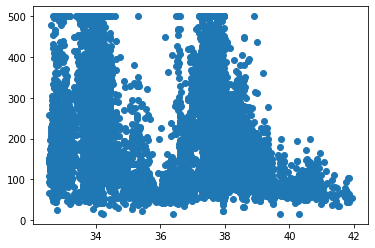

In [16]:
plt.scatter(X_train["latitude"], y_train["median_house_value"])

## 3. Model with Minimal Features with bucketizing 'latitute'


In [0]:
def select_and_transform_features(source_df):
  LATITUDE_RANGES = zip(range(32, 44), range(33, 45))
  # print("LATITUDE_RANGES:{}".format(LATITUDE_RANGES))
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  for r in LATITUDE_RANGES:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_examples

selected_training_examples = select_and_transform_features(X_train)
selected_validation_examples = select_and_transform_features(X_val)

In [18]:
model_3 = train_model(learning_rate=0.01,
                optimizer='SGD',
                steps=500,
                batch_size=5,
                feature_columns = construct_feature_columns(selected_training_examples),
                training_examples=selected_training_examples,
                training_targets= y_train,
                validation_examples=selected_validation_examples,
                validation_targets=y_val)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp511quby5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc66c6c0080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
INFO:tensorfl

In [19]:
selected_test_examples = select_and_transform_features(X_test)

predict_test_input_fn = lambda: my_input_fn(selected_test_examples, y_test["median_house_value"], count=1, shuffle=False)

y_hat_test = model_3.predict(input_fn=predict_test_input_fn)
y_hat_test = np.array([item['predictions'][0] for item in y_hat_test])

root_mean_squared_error = math.sqrt( metrics.mean_squared_error(y_hat_test, y_test))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp511quby5/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Final RMSE (on test data): 112.57


## 4. Train the Model on Bucketized Feature Columns

In [0]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  # print("feature_values:{}, num_buckets:{}".format(feature_values, num_buckets))
  # print(np.arange(1.0, num_buckets))
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  
  #print("Boundaries:{}".format(boundaries))
  quantiles = feature_values.quantile(boundaries)
  # print("quantiles:{}".format(quantiles))
  # print("quantiles.keys():{}".format(quantiles.keys()))
  # for q in quantiles.keys():
  #   print("q:{},qunatiles[q]:{}".format(q, quantiles[q]))
  return [quantiles[q] for q in quantiles.keys()]

# Divide households into 7 buckets.
households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(households, boundaries=get_quantile_based_boundaries( X_train["households"], 7))
# print("households:{}".format(households))
# print("bucketized_households:{}".format(bucketized_households))
# Divide longitude into 10 buckets.
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column( longitude, boundaries=get_quantile_based_boundaries( X_train["longitude"], 10) )

In [0]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column( households, boundaries=get_quantile_based_boundaries( X_train["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column( longitude, boundaries=get_quantile_based_boundaries( X_train["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column( latitude, boundaries=get_quantile_based_boundaries( X_train["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column( housing_median_age, boundaries=get_quantile_based_boundaries( X_train["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column( median_income, boundaries=get_quantile_based_boundaries( X_train["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column( rooms_per_person, boundaries=get_quantile_based_boundaries( X_train["rooms_per_person"], 7))
  
  feature_columns = set([ bucketized_longitude, bucketized_latitude, bucketized_housing_median_age, bucketized_households, bucketized_median_income, bucketized_rooms_per_person])
  print(feature_columns)
  return feature_columns

In [22]:
model_4 = train_model(learning_rate=3.0,
                      optimizer = 'Ftrl',
                      steps=500,
                      batch_size=100,
                      feature_columns=construct_feature_columns(),
                      training_examples=X_train,
                      training_targets=y_train,
                      validation_examples=X_val,
                      validation_targets=y_val)

{BucketizedColumn(source_column=NumericColumn(key='rooms_per_person', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.2513956597046345, 1.594056656645094, 1.8426744003186517, 2.038190818900005, 2.2390078868987606, 2.5173307865711694)), BucketizedColumn(source_column=NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(219.0, 299.0, 371.0, 451.0, 568.0, 771.2857142857138)), BucketizedColumn(source_column=NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(15.0, 20.0, 26.0, 32.0, 36.0, 43.0)), BucketizedColumn(source_column=NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(33.63, 33.86, 34.0, 34.09, 34.25, 36.67, 37.48, 37.81, 38.49)), BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalize

In [23]:
predict_test_input_fn = lambda: my_input_fn(X_test, y_test["median_house_value"], count=1, shuffle=False)

y_hat_test = model_4.predict(input_fn=predict_test_input_fn)
y_hat_test = np.array([item['predictions'][0] for item in y_hat_test])

root_mean_squared_error = math.sqrt( metrics.mean_squared_error(y_hat_test, y_test))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpalgolqlt/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Final RMSE (on test data): 67.84


## 5. Training the Model using Feature Crosses

**Adding a feature cross of 'longitude' and 'latitude' to model to check improvement in results. Using a hash_bucket_size` of '1000'**

Reference: to the TensorFlow API docs for [`crossed_column()`](https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column) to build the feature column for your cross. 

In [0]:
def construct_feature_columns(training_examples):
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column( households, boundaries=get_quantile_based_boundaries( training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column( longitude, boundaries=get_quantile_based_boundaries( training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column( latitude, boundaries=get_quantile_based_boundaries( training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column( housing_median_age, boundaries=get_quantile_based_boundaries( training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column( median_income, boundaries=get_quantile_based_boundaries( training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column( rooms_per_person, boundaries=get_quantile_based_boundaries( training_examples["rooms_per_person"], 7))
  
  # Making a feature column for the long_x_lat feature cross
  long_x_lat = tf.feature_column.crossed_column( set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)  
  
  feature_columns = set([ bucketized_longitude,
                          bucketized_latitude,
                          bucketized_housing_median_age,
                          bucketized_households,
                          bucketized_median_income,
                          bucketized_rooms_per_person,
                          long_x_lat])
                        
  return feature_columns

In [25]:
model_5 = train_model(learning_rate=3.0,
                      optimizer='Ftrl',
                      steps=500,
                      batch_size=100,
                      feature_columns=construct_feature_columns(X_train),
                      training_examples=X_train,
                      training_targets=y_train,
                      validation_examples=X_val,
                      validation_targets=y_val)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsdbnx27v', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc6686da0f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
INFO:tensorfl

In [26]:
predict_test_input_fn = lambda: my_input_fn(X_test, y_test["median_house_value"], count=1, shuffle=False)

y_hat_test = model_5.predict(input_fn=predict_test_input_fn)
y_hat_test = np.array([item['predictions'][0] for item in y_hat_test])

root_mean_squared_error = math.sqrt( metrics.mean_squared_error(y_hat_test, y_test))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpsdbnx27v/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Final RMSE (on test data): 62.96
